In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, max, isnan, when, desc, udf, regexp_extract, hour, count, lit
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType
import re

spark = SparkSession.builder.master("local").appName("demo1").getOrCreate()

import warnings
warnings.filterwarnings('ignore')

23/05/20 00:30:23 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
#import data
df = spark.read.load('hdfs://orion11:11001/Project3/Part2/NYPD_Complaint_Data_Historic.csv'
                     , format='csv', sep=','
                     , inferSchema='true'
                     , header='true')

In [3]:
df.take(2)

23/05/19 18:34:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(CMPLNT_NUM='469069650', CMPLNT_FR_DT='09/04/2019', CMPLNT_FR_TM=datetime.datetime(2023, 5, 19, 9, 0), CMPLNT_TO_DT='09/04/2019', CMPLNT_TO_TM='10:00:00', ADDR_PCT_CD=9, RPT_DT='09/04/2019', KY_CD=341, OFNS_DESC='PETIT LARCENY', PD_CD=321, PD_DESC='LARCENY,PETIT FROM AUTO', CRM_ATPT_CPTD_CD='COMPLETED', LAW_CAT_CD='MISDEMEANOR', BORO_NM='MANHATTAN', LOC_OF_OCCUR_DESC='REAR OF', PREM_TYP_DESC=None, JURIS_DESC='N.Y. POLICE DEPT', JURISDICTION_CODE=0, PARKS_NM=None, HADEVELOPT=None, HOUSING_PSA=None, X_COORD_CD=989667, Y_COORD_CD=203049, SUSP_AGE_GROUP=None, SUSP_RACE=None, SUSP_SEX=None, TRANSIT_DISTRICT=None, Latitude=40.724005870000035, Longitude=-73.98045825599996, Lat_Lon='(40.724005870000035, -73.98045825599996)', PATROL_BORO='PATROL BORO MAN SOUTH', STATION_NAME=None, VIC_AGE_GROUP='25-44', VIC_RACE='BLACK', VIC_SEX='F'),
 Row(CMPLNT_NUM='629841380', CMPLNT_FR_DT='08/31/2019', CMPLNT_FR_TM=datetime.datetime(2023, 5, 19, 18, 58), CMPLNT_TO_DT='08/31/2019', CMPLNT_TO_TM='19:03:00

In [4]:
df.dtypes

[('CMPLNT_NUM', 'string'),
 ('CMPLNT_FR_DT', 'string'),
 ('CMPLNT_FR_TM', 'timestamp'),
 ('CMPLNT_TO_DT', 'string'),
 ('CMPLNT_TO_TM', 'string'),
 ('ADDR_PCT_CD', 'int'),
 ('RPT_DT', 'string'),
 ('KY_CD', 'int'),
 ('OFNS_DESC', 'string'),
 ('PD_CD', 'int'),
 ('PD_DESC', 'string'),
 ('CRM_ATPT_CPTD_CD', 'string'),
 ('LAW_CAT_CD', 'string'),
 ('BORO_NM', 'string'),
 ('LOC_OF_OCCUR_DESC', 'string'),
 ('PREM_TYP_DESC', 'string'),
 ('JURIS_DESC', 'string'),
 ('JURISDICTION_CODE', 'int'),
 ('PARKS_NM', 'string'),
 ('HADEVELOPT', 'string'),
 ('HOUSING_PSA', 'string'),
 ('X_COORD_CD', 'int'),
 ('Y_COORD_CD', 'int'),
 ('SUSP_AGE_GROUP', 'string'),
 ('SUSP_RACE', 'string'),
 ('SUSP_SEX', 'string'),
 ('TRANSIT_DISTRICT', 'int'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Lat_Lon', 'string'),
 ('PATROL_BORO', 'string'),
 ('STATION_NAME', 'string'),
 ('VIC_AGE_GROUP', 'string'),
 ('VIC_RACE', 'string'),
 ('VIC_SEX', 'string')]

In [5]:
#####Clean the data
# Dropping rows with NaN values in specific columns
df = df.dropna(subset=['Y_COORD_CD','X_COORD_CD','Latitude','Longitude','CRM_ATPT_CPTD_CD','CMPLNT_FR_TM','Lat_Lon','CMPLNT_FR_DT','BORO_NM','OFNS_DESC'])

# Dropping columns that are not significant for future data exploration
df = df.drop(*['PARKS_NM','STATION_NAME','TRANSIT_DISTRICT','HADEVELOPT','HOUSING_PSA','PREM_TYP_DESC','SUSP_AGE_GROUP','SUSP_SEX','SUSP_RACE','JURISDICTION_CODE','ADDR_PCT_CD','PD_CD','PD_DESC','PATROL_BORO','CMPLNT_TO_DT','CMPLNT_TO_TM'])

# Replacing NaN values in 'LOC_OF_OCCUR_DESC', 'VIC_RACE', 'VIC_AGE_GROUP', 'VIC_SEX' with 'UNKNOWN'
df = df.fillna('UNKNOWN', subset=['LOC_OF_OCCUR_DESC','VIC_RACE','VIC_AGE_GROUP','VIC_SEX'])

# Print the shape of the cleaned dataset
print('Clean dataset:')
print('Observations:', df.count())
print('Variables:', len(df.columns))

# Examine the changes
df.show(5)

Clean dataset:


Observations: 8308403
Variables: 19
+----------+------------+-------------------+----------+-----+-------------+----------------+-----------+---------+-----------------+----------------+----------+----------+------------------+------------------+--------------------+-------------+--------+-------+
|CMPLNT_NUM|CMPLNT_FR_DT|       CMPLNT_FR_TM|    RPT_DT|KY_CD|    OFNS_DESC|CRM_ATPT_CPTD_CD| LAW_CAT_CD|  BORO_NM|LOC_OF_OCCUR_DESC|      JURIS_DESC|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lat_Lon|VIC_AGE_GROUP|VIC_RACE|VIC_SEX|
+----------+------------+-------------------+----------+-----+-------------+----------------+-----------+---------+-----------------+----------------+----------+----------+------------------+------------------+--------------------+-------------+--------+-------+
| 469069650|  09/04/2019|2023-05-19 09:00:00|09/04/2019|  341|PETIT LARCENY|       COMPLETED|MISDEMEANOR|MANHATTAN|          REAR OF|N.Y. POLICE DEPT|    989667|    203049|40.

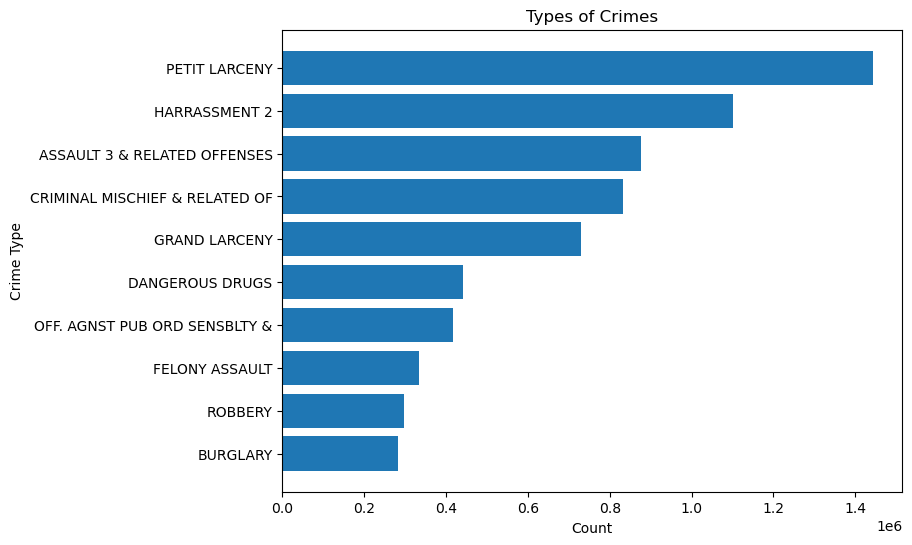

In [6]:
top_crimes = df.groupBy("OFNS_DESC").count().orderBy(desc("count")).limit(10)

# Convert the DataFrame to Pandas for plotting
top_crimes_list = top_crimes.collect()

# Extract the crime types and counts into separate lists
crime_types = [row.OFNS_DESC for row in top_crimes_list]
crime_counts = [row["count"] for row in top_crimes_list]

# Plot the bar chart using PySpark
plt.figure(figsize=(8, 6))
plt.barh(crime_types, crime_counts)
plt.gca().invert_yaxis()
plt.title("Types of Crimes")
plt.xlabel("Count")
plt.ylabel("Crime Type")
plt.show()


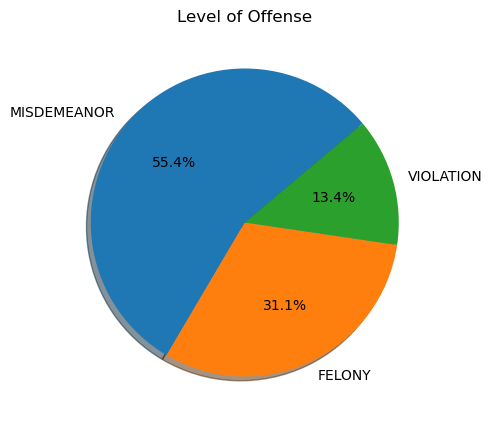

In [7]:
# Perform value counts
offense_counts = df.groupBy("LAW_CAT_CD").count().orderBy(desc("count"))

# Convert the DataFrame to Pandas for plotting
offense_counts_list = offense_counts.collect()

# Extract the offense levels and counts into separate lists
offense_levels = [row.LAW_CAT_CD for row in offense_counts_list]
offense_counts = [row["count"] for row in offense_counts_list]

# Plot the pie chart using PySpark
plt.figure(figsize=(10, 5))
plt.pie(offense_counts, labels=offense_levels, autopct='%1.1f%%', startangle=40, shadow=True)
plt.title("Level of Offense")
plt.show()

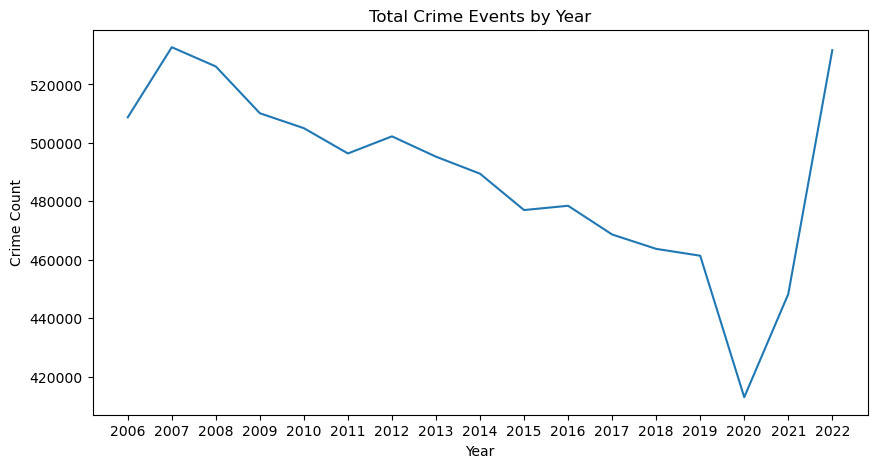

In [8]:
# Extract the year using regular expression and create a new column 'year'
df = df.withColumn("year", regexp_extract("RPT_DT", r"\d{4}", 0))

# Perform value counts
year_counts = df.groupBy("year").count().orderBy("year")

# Convert the DataFrame to Pandas for plotting
year_counts_list = year_counts.collect()

# Extract the years and counts into separate lists
years = [row.year for row in year_counts_list]
crime_counts = [row["count"] for row in year_counts_list]

# Plot the line chart using PySpark
plt.figure(figsize=(10, 5))
plt.plot(years, crime_counts)
plt.title("Total Crime Events by Year")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.show()

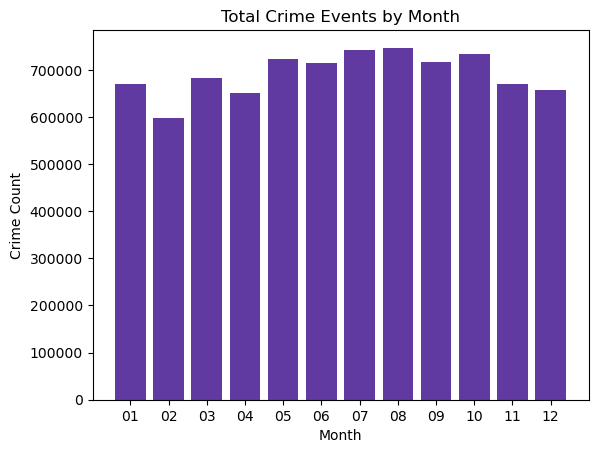

In [17]:
# Extract the month using regular expression and create a new column 'month'
df = df.withColumn("month", regexp_extract("RPT_DT", r"(\d{2})", 1))

# Group by month and get the count
month_counts = df.groupBy("month").count().orderBy("month")

# Collect the result into a list of Row objects
counts_list = month_counts.collect()

# Extract the month and count values from the list
months = [row['month'] for row in counts_list]
counts = [row['count'] for row in counts_list]

# Plot the bar chart using Matplotlib
plt.bar(months, counts, color="#603AA1")
plt.title("Total Crime Events by Month")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.show()


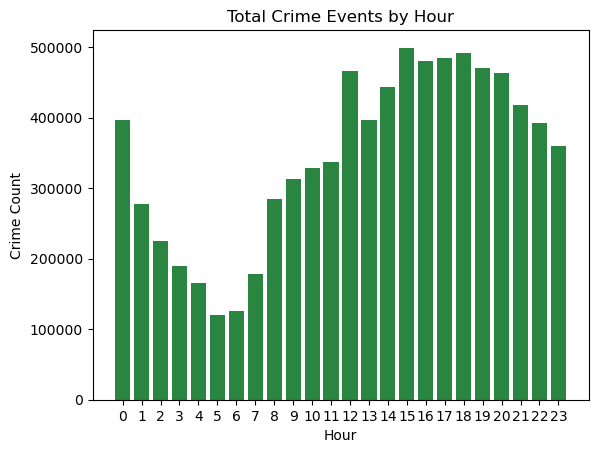

In [19]:
# Extract the hour from the 'CMPLNT_FR_TM' column
df = df.withColumn("hour", hour("CMPLNT_FR_TM"))

# Group by hour and get the count
hour_counts = df.groupBy("hour").count().orderBy("hour")

# Convert the hour values to strings
hour_counts = hour_counts.withColumn("hour", hour_counts["hour"].cast("string"))

# Collect the result into a list of Row objects
counts_list = hour_counts.collect()

# Extract the hour and count values from the list
hours = [row['hour'] for row in counts_list]
counts = [row['count'] for row in counts_list]

# Plot the bar chart using Matplotlib
plt.bar(hours, counts, color="#298540")
plt.title("Total Crime Events by Hour")
plt.xlabel("Hour")
plt.ylabel("Crime Count")
plt.show()


In [11]:
# Filter the DataFrame to include rows where the 'OFNS_DESC' column contains 'SEX CRIMES' or 'RAPE'
sex_crimes = df.filter(col("OFNS_DESC").rlike("SEX CRIMES|RAPE"))

# Show the first few rows of the filtered DataFrame
sex_crimes.show()


+----------+------------+-------------------+----------+-----+----------+----------------+-----------+---------+-----------------+----------------+----------+----------+------------------+------------------+--------------------+-------------+--------------------+-------+----+-----+----+
|CMPLNT_NUM|CMPLNT_FR_DT|       CMPLNT_FR_TM|    RPT_DT|KY_CD| OFNS_DESC|CRM_ATPT_CPTD_CD| LAW_CAT_CD|  BORO_NM|LOC_OF_OCCUR_DESC|      JURIS_DESC|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lat_Lon|VIC_AGE_GROUP|            VIC_RACE|VIC_SEX|year|month|hour|
+----------+------------+-------------------+----------+-----+----------+----------------+-----------+---------+-----------------+----------------+----------+----------+------------------+------------------+--------------------+-------------+--------------------+-------+----+-----+----+
| 343363487|  10/28/2012|2023-05-19 05:00:00|06/27/2017|  233|SEX CRIMES|       COMPLETED|MISDEMEANOR|    BRONX|          UNKNOWN|N.Y. P

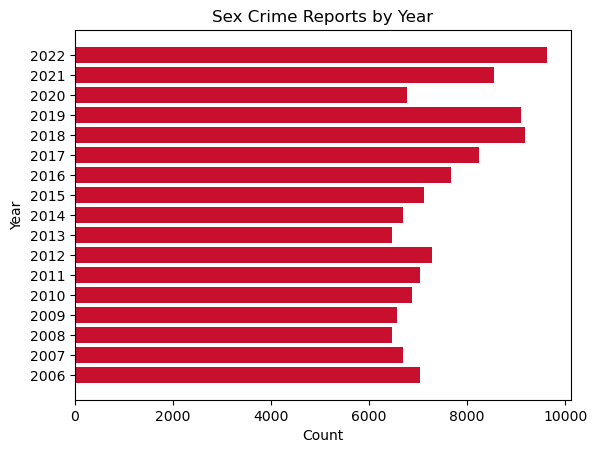

7494.18


In [20]:
# Group by year and count the number of occurrences
crime_counts = sex_crimes.groupBy("year").agg(count("*").alias("count")).orderBy("year")

# Convert the DataFrame to Pandas for plotting
crime_counts_list = crime_counts.collect()

# Extract year and count values from the DataFrame
years = [row["year"] for row in crime_counts_list]
counts = [row["count"] for row in crime_counts_list]

# Plot the bar graph using Matplotlib
plt.barh(years, counts, color='#C8102E')
plt.title("Sex Crime Reports by Year")
plt.xlabel("Count")
plt.ylabel("Year")
plt.show()

# Calculate average sex crimes per year
mean = crime_counts.selectExpr("avg(count)").first()[0]
print(round(mean, 2))


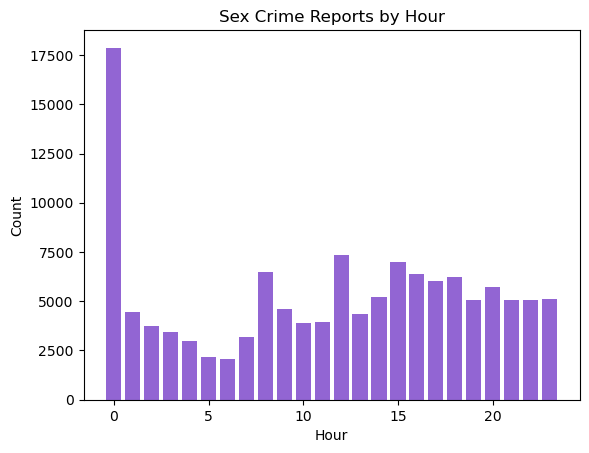

In [21]:
# Extract the hour from the 'CMPLNT_FR_TM' column
sex_crimes = sex_crimes.withColumn("hour", hour("CMPLNT_FR_TM"))

# Group by hour and count the number of occurrences
crime_counts = sex_crimes.groupBy("hour").agg(count("*").alias("count")).orderBy("hour")

# Convert the DataFrame to Pandas for plotting
crime_counts_list = crime_counts.collect()

# Extract hour and count values from the DataFrame
hours = [row["hour"] for row in crime_counts_list]
counts = [row["count"] for row in crime_counts_list]

# Plot the bar graph using Matplotlib
plt.bar(hours, counts, color='#9265D3')
plt.title("Sex Crime Reports by Hour")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()



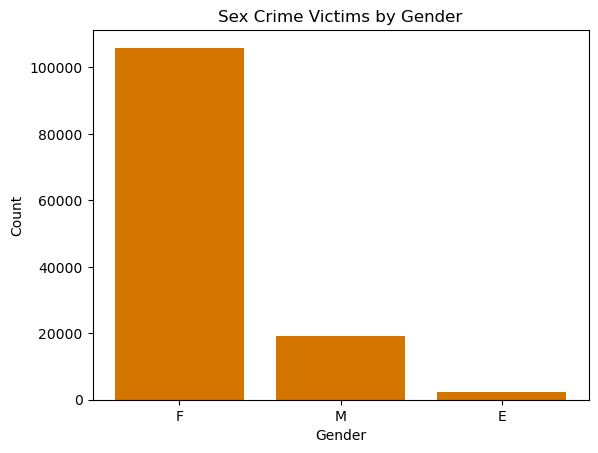

+-------+--------------------+
|VIC_SEX|          percentage|
+-------+--------------------+
|      F|   83.13749499611463|
|      E|  1.7072079497021215|
|      M|   15.04383796045557|
|      D| 0.10988924733714807|
|      L|7.849231952653434E-4|
|UNKNOWN|7.849231952653434E-4|
+-------+--------------------+



In [22]:
# Group by 'VIC_SEX' and count the number of occurrences
crime_counts = sex_crimes.groupBy("VIC_SEX").agg(count("*").alias("count"))

# Sort the counts in descending order and limit to the top 3
top_victims = crime_counts.orderBy(col("count").desc()).limit(3)

# Convert the DataFrame to Pandas for plotting
top_victims_list = top_victims.collect()

# Extract VIC_SEX and count values from the DataFrame
vic_sex = [row["VIC_SEX"] for row in top_victims_list]
counts = [row["count"] for row in top_victims_list]

# Plot the bar graph using Matplotlib
plt.bar(vic_sex, counts, color='#D47500')
plt.title("Sex Crime Victims by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# Calculate the percentage of victims by gender
total_count = sex_crimes.count()
vic_sex_per = crime_counts.withColumn("percentage", (col("count") / lit(total_count)) * 100).select("VIC_SEX", "percentage")
vic_sex_per.show()


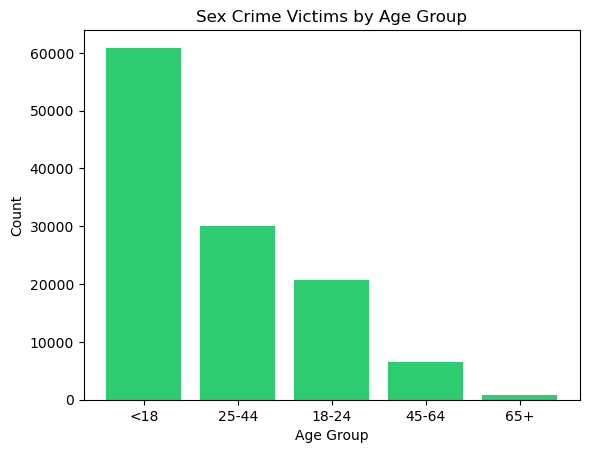

+-------------+------------------+
|VIC_AGE_GROUP|        percentage|
+-------------+------------------+
|          <18| 47.79632812929255|
|        25-44| 23.53906170281238|
|        18-24|16.290295994536937|
|        45-64| 5.093366614076813|
|          65+|0.6200893242596212|
+-------------+------------------+



In [15]:
# Group by 'VIC_AGE_GROUP' and count the number of occurrences
crime_counts = sex_crimes.groupBy("VIC_AGE_GROUP").agg(count("*").alias("count"))

# Select the desired age groups and sort the counts in descending order
selected_age_groups = ["<18", "18-24", "25-44", "45-64", "65+"]

filtered_counts = crime_counts.filter(col("VIC_AGE_GROUP").isin(selected_age_groups))
filtered_counts = filtered_counts.orderBy(col("count").desc())

# Convert the DataFrame to Pandas for plotting
filtered_counts_list = filtered_counts.collect()

# Extract VIC_AGE_GROUP and count values from the DataFrame
vic_age_group = [row["VIC_AGE_GROUP"] for row in filtered_counts_list]
counts = [row["count"] for row in filtered_counts_list]

# Plot the bar graph using Matplotlib
plt.bar(vic_age_group, counts, color='#2ECC71')
plt.title("Sex Crime Victims by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

# Calculate the percentage of victims by age group
total_count = sex_crimes.count()
vic_age_per = filtered_counts.withColumn("percentage", (col("count") / lit(total_count)) * 100).select("VIC_AGE_GROUP", "percentage")
vic_age_per.show()


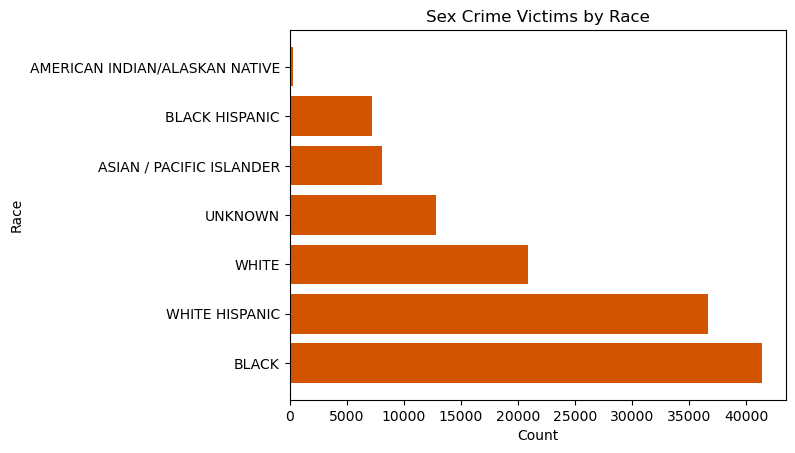

+--------------------+------------------+
|            VIC_RACE|        percentage|
+--------------------+------------------+
|               BLACK|32.487186128837294|
|      WHITE HISPANIC|28.745457257007402|
|               WHITE|16.397830472288284|
|             UNKNOWN| 10.09175752152652|
|ASIAN / PACIFIC I...| 6.330405569814994|
|      BLACK HISPANIC| 5.672639932182636|
|AMERICAN INDIAN/A...|0.2723683487570741|
+--------------------+------------------+



In [16]:
# Group by 'VIC_RACE' and count the number of occurrences
crime_counts = sex_crimes.groupBy("VIC_RACE").agg(count("*").alias("count"))

# Sort the counts in descending order and limit to the top 7
top_victims = crime_counts.orderBy(col("count").desc()).limit(7)

# Convert the DataFrame to Pandas for plotting
top_victims_list = top_victims.collect()

# Extract VIC_RACE and count values from the DataFrame
vic_race = [row["VIC_RACE"] for row in top_victims_list]
counts = [row["count"] for row in top_victims_list]

# Plot the bar graph using Matplotlib
plt.barh(vic_race, counts, color='#D35400')
plt.title("Sex Crime Victims by Race")
plt.xlabel("Count")
plt.ylabel("Race")
plt.show()

# Calculate the percentage of victims by race
total_count = sex_crimes.count()
vic_race_per = top_victims.withColumn("percentage", (col("count") / lit(total_count)) * 100).select("VIC_RACE", "percentage")
vic_race_per.show()
